Information Gain for each feature:

Gender: 0.0007
Age: 0.0013
BMI: 0.0003
Smoking: 0.0000
Exercise: 0.0054
Diabetes: 0.0001
Drinking_Habit: 0.0004
Hypertension: 0.0005


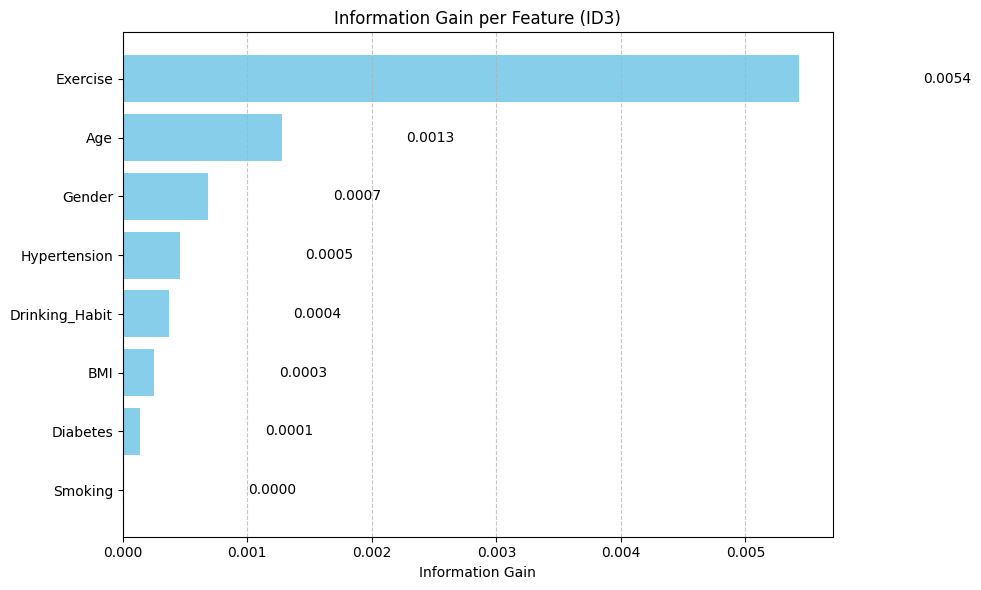

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from math import log2
import matplotlib.pyplot as plt
import networkx as nx

# Load and clean the dataset
df = pd.read_csv("sleep_health.csv")
df = df.dropna()

# Create the dataframe
df_2015 = pd.DataFrame({
    "Poor_Sleep": df["2015NRS"],
    "Gender": df["gender"],
    "Age": df["2015Age"],
    "BMI": df["2015BMI"],
    "Smoking": df["2015Smoking"],
    "Exercise": df["2015EX"],
    "Diabetes": df["2015Diabetes"],
    "Drinking_Habit": df["2015DrinkHabit"],
    "Hypertension" : df["2015Hypertension"]
})

# Bin Age and BMI
df_2015["Age"] = pd.cut(df_2015["Age"], bins=[39, 49, 59, 69, 74], labels=["40–49", "50–59", "60–69", "70–74"])
df_2015["BMI"] = pd.cut(df_2015["BMI"], bins=[0, 18.5, 25, float("inf")], labels=["Underweight", "Normal", "Overweight"])

# Encode all categorical columns
le = LabelEncoder()
for col in df_2015.columns:
    df_2015[col] = le.fit_transform(df_2015[col])

# Entropy
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

# Info Gain
def info_gain(df, feature, target):
    total_entropy = entropy(df[target])
    values, counts = np.unique(df[feature], return_counts=True)
    
    weighted_entropy = 0
    for v, count in zip(values, counts):
        subset = df[df[feature] == v]
        weighted_entropy += (count / len(df)) * entropy(subset[target])
    
    return total_entropy - weighted_entropy

# Calculate and print info gain
target = "Poor_Sleep"
features = [col for col in df_2015.columns if col != target]

info_gain_dict = {}

print("Information Gain for each feature:\n")
for feature in features:
    gain = info_gain(df_2015, feature, target)
    info_gain_dict[feature] = gain
    print(f"{feature}: {gain:.4f}")

info_gain_df = pd.DataFrame(list(info_gain_dict.items()), columns=["Feature", "Information Gain"])
info_gain_df.sort_values("Information Gain", ascending=True, inplace=True)

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(info_gain_df["Feature"], info_gain_df["Information Gain"], color='skyblue')
plt.xlabel("Information Gain")
plt.title("Information Gain per Feature (ID3)")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Add info gain values to the end of each bar
for bar in bars:
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.4f}", va='center')

plt.tight_layout()
plt.show()

# Already done — use original df_2015
info_gain_dict_unbalanced = {feat: info_gain(df_2015, feat, "Poor_Sleep") for feat in features}
info_gain_df_unbalanced = pd.DataFrame(info_gain_dict_unbalanced.items(), columns=["Feature", "Information Gain"])

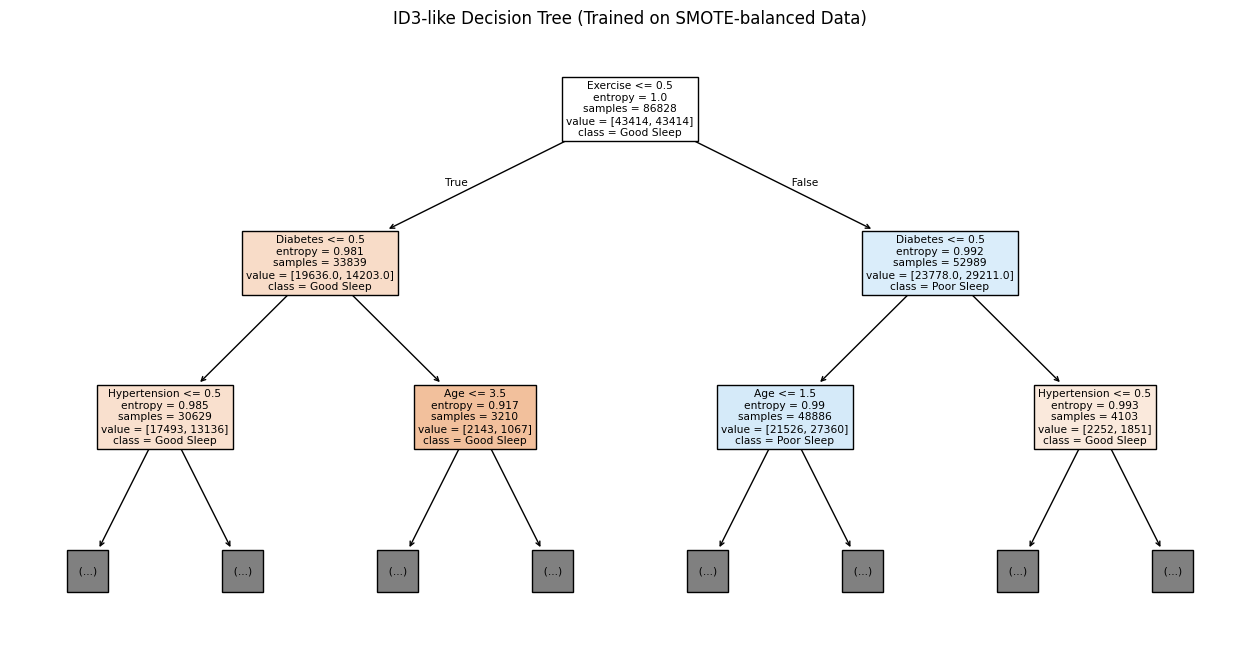

Information Gain for Each Feature:
       Feature  Information Gain
      Exercise          0.321878
           Age          0.176211
Drinking_Habit          0.108395
  Hypertension          0.098673
           BMI          0.098564
       Smoking          0.071087
      Diabetes          0.065691
        Gender          0.059501


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE

# Prepare the Data
y = df_2015["Poor_Sleep"]
X = df_2015.drop(columns="Poor_Sleep")

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Train
clf = DecisionTreeClassifier(criterion="entropy", max_depth=8, random_state=42)
clf.fit(X_resampled, y_resampled)

# Plot Decision Tree
plt.figure(figsize=(16, 8))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=["Good Sleep", "Poor Sleep"],
    filled=True,
    max_depth=2
)
plt.title("ID3-like Decision Tree (Trained on SMOTE-balanced Data)")
plt.show()

# Information 
importances = clf.feature_importances_

info_gain_df = pd.DataFrame({
    "Feature": X.columns,
    "Information Gain": importances
}).sort_values(by="Information Gain", ascending=False)

print("Information Gain for Each Feature:")
print(info_gain_df.to_string(index=False))

from imblearn.over_sampling import SMOTE

X = df_2015.drop(columns="Poor_Sleep")
y = df_2015["Poor_Sleep"]

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Rebuild a DataFrame for consistency
df_smote = pd.DataFrame(X_resampled, columns=X.columns)
df_smote["Poor_Sleep"] = y_resampled

# Recalculate info gain
info_gain_dict_balanced = {feat: info_gain(df_smote, feat, "Poor_Sleep") for feat in features}
info_gain_df_balanced = pd.DataFrame(info_gain_dict_balanced.items(), columns=["Feature", "Information Gain"])



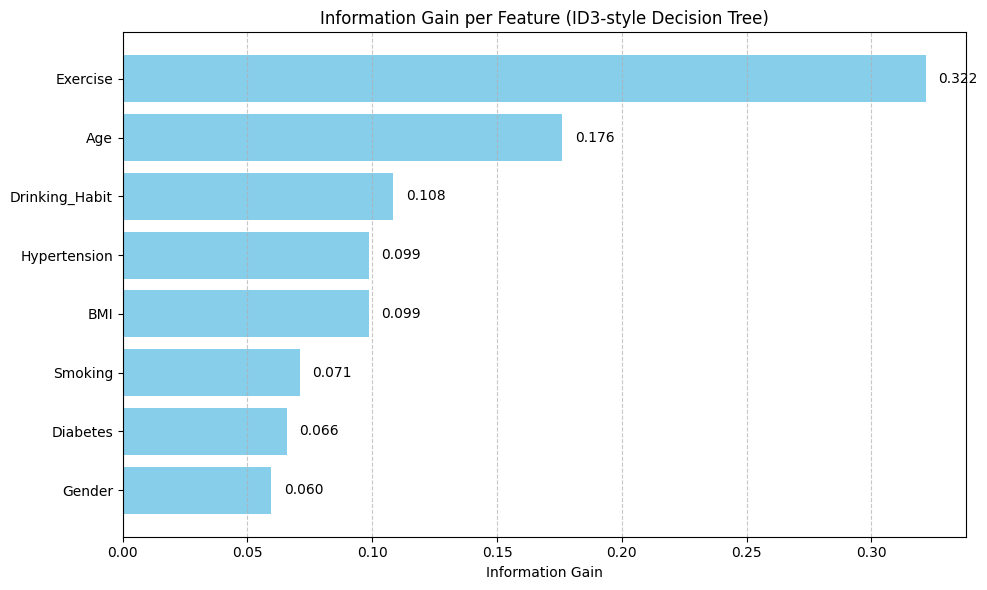

In [48]:
# --- 6. Plot Information Gain as Horizontal Bar Chart ---
# Sort ascending for horizontal bar chart layout
info_gain_df_sorted = info_gain_df.sort_values(by="Information Gain", ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(info_gain_df_sorted["Feature"], info_gain_df_sorted["Information Gain"], color='skyblue')
plt.xlabel("Information Gain")
plt.title("Information Gain per Feature (ID3-style Decision Tree)")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Annotate each bar with its value
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}", va='center', ha='left')

plt.tight_layout()
plt.show()


In [49]:
# Merge for side-by-side comparison
compare_df = info_gain_df_unbalanced.merge(
    info_gain_df_balanced, on="Feature", suffixes=("_Unbalanced", "_SMOTE")
).sort_values("Information Gain_SMOTE", ascending=False)

print(compare_df)


          Feature  Information Gain_Unbalanced  Information Gain_SMOTE
4        Exercise                     0.005430                0.011914
1             Age                     0.001277                0.003970
5        Diabetes                     0.000141                0.002723
7    Hypertension                     0.000463                0.001356
0          Gender                     0.000688                0.000704
3         Smoking                     0.000003                0.000646
6  Drinking_Habit                     0.000370                0.000576
2             BMI                     0.000252                0.000113
